In [1]:
import utils
from utils import *

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import fbeta_score
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint

%matplotlib inline


from sklearn.preprocessing import StandardScaler

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: unknown error)


In [12]:
train_features = load_array("data/cache/train_features_extrasvd_v2.dat")
test_features = load_array("data/cache/test_features_extrasvd_v2.dat" )
col_labels = load_array("data/cache/col_labels_extrasv2v2.dat")

In [15]:
train_features.shape,test_features.shape

((404290, 124), (2345796, 124))

In [11]:
# train_features = load_array("data/cache/all_features_v3_triangle_train.dat")
# test_features = load_array("data/cache/all_features_v3_triangle_test.dat")


# train_features = np.nan_to_num(train_features)
# test_features = np.nan_to_num(test_features)


In [3]:
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))


In [47]:

np.random.seed(2189)

perm = np.random.permutation(len(train_features))
ix_fit = perm[:int(len(train_features)*(1-0.1))]
ix_valid = perm[int(len(train_features)*(1-0.1)):]


In [48]:
num_folds = 5
X = train_features
X_submission = test_features

# X = np.clip(X,X.min(),1e7)
# X_submission = np.clip(X_submission,X_submission.min(),1e7)

X_train = np.nan_to_num(StandardScaler().fit_transform(X[ix_fit]))
X_valid = np.nan_to_num(StandardScaler().fit_transform(X[ix_valid]))



In [49]:
y = labels

y_val = labels[ix_valid]
y_train = labels[ix_fit]

### Model

In [50]:
def NN():
    nf=64; p=0.5

    num_hidden1 = np.random.randint(512, 1024)
    num_hidden2 = np.random.randint(512, 1024)
    rate_drop_1 = 0.3 + np.random.rand() * 0.25
    rate_drop_2 = 0.3 + np.random.rand() * 0.25

    STAMP = 'NN_%d_%d_%.2f_%.2f'%(num_hidden1, num_hidden2, rate_drop_1, \
            rate_drop_2)


    print STAMP


    layers =  [
        Dense(num_hidden1,activation='relu',input_shape =  (train_features.shape[1],)),
        Dropout(rate_drop_1),   
        BatchNormalization(),


        Dense(num_hidden2,activation='relu'),
        Dropout(rate_drop_2),   
        BatchNormalization(),


        Dense(1,activation='sigmoid')]


    return  Sequential(layers), STAMP

In [51]:
model,_ =NN()

NN_835_670_0.44_0.32


In [52]:
kfold_weights_path = "weights/NN_features.h5"
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True)]


In [53]:

# class_weight = {0: 1.309028344, 1: 0.472001959}


# weight_val = np.ones(len(y_val))
# weight_val *= 0.472001959
# weight_val[y_val==0] = 1.309028344


In [54]:
#0.2148


model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(x = X_train, y= y_train, validation_data=(X_valid, y_val),#weight_val
  batch_size=128, epochs=50,callbacks=callbacks,   shuffle=True,verbose=1)
#class_weight=class_weight,

Train on 363861 samples, validate on 40429 samples
Epoch 1/50
 49664/363861 [===>..........................] - ETA: 49s - loss: 0.3020 - acc: 0.8656

KeyboardInterrupt: 

In [36]:
pred_val = model.predict(X_valid)

In [41]:
pred_val = np.clip(pred_val,1e-5,0.9999)

In [42]:
log_loss(y_val,pred_val)

0.21925120361546097

In [17]:
model.predict(X_valid, batch_size=1024, verbose=1).reshape(-1,1)

40429/40429 [==============================] - 4s     


array([[ 0.88276333],
       [ 0.00097097],
       [ 0.00423541],
       ..., 
       [ 0.13323547],
       [ 0.14245816],
       [ 0.89202607]], dtype=float32)

## Kfolding

In [55]:

y_oof = np.zeros((train_features.shape[0],1))
test_preds = np.zeros((test_features.shape[0],1))
val_scores = []


num_iters = 1
for i in range(num_iters):

    model,STAMP =NN()


    kfold_weights_path = "weights/NN_oof_{}.h5".format(STAMP)
    callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True)]


    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


    num_folds = 5 
    skf = StratifiedKFold(n_splits=num_folds, random_state=2019)
    splits = skf.split(train_features, labels)

    for ix_fit, ix_valid in tqdm_notebook(splits, total=num_folds):
        y_val = labels[ix_valid]
        y_train = labels[ix_fit]

        X_train = np.nan_to_num(StandardScaler().fit_transform(train_features[ix_fit]))
        X_valid = np.nan_to_num(StandardScaler().fit_transform(train_features[ix_valid]))



        history = model.fit(x = X_train, y= y_train, validation_data=(X_valid, y_val),
          batch_size=128, epochs=100,callbacks=callbacks,  shuffle=True,verbose=1)



        bst_val_score = min(history.history['val_loss'])
        tqdm.write("bst_val_score:{}".format(bst_val_score) )
        val_scores.append(bst_val_score)



        tqdm.write('Start making the submission before fine-tuning')
        model.load_weights(kfold_weights_path)


        y_oof[ix_valid] += model.predict(X_valid, batch_size=2048, verbose=1).reshape(-1,1)

        test_preds += model.predict(X_submission, batch_size=2048, verbose=1).reshape(-1,1)
        # preds += model.predict([test_data_2, test_data_1,abhishek_np_test], batch_size=8192, verbose=1)





NN_949_668_0.51_0.46


Train on 323431 samples, validate on 80859 samples
Epoch 1/100
 64256/323431 [====>.........................] - ETA: 45s - loss: 0.3645 - acc: 0.8390

KeyboardInterrupt: 

### Multiple NN models  

In [9]:
val_preds = load_array("data/results/val_preds.dat")
test_preds = load_array("data/results/test_preds.dat")
val_scores = load_array("data/results/scores.dat")



In [10]:
val_preds /= 10.0
test_preds /= 10.0

In [11]:
val_preds.shape,test_preds.shape

((40429, 1), (2345796, 1))

In [5]:
val_scores

array([ 0.15615973,  0.15582112,  0.15680597,  0.15562001,  0.15561428,
        0.15630357,  0.15600083,  0.1585689 ,  0.15674927,  0.15547462])

In [21]:
log_loss(y_val,val_preds)

0.24419280908020721

### Blending

In [35]:
xgbpred = load_array("data/cache/xgb_valpreds_graph_features.dat/").reshape(-1)
nnpred= val_preds.reshape(-1)

In [50]:
from scipy.optimize import minimize

def optimize_weights(preds, y):
    def mlogloss(x):
        weights = np.exp(x)/np.sum(np.exp(x))
        pred = sum([p*w for (p,w) in zip(preds,weights)])
        return log_loss(y, pred)
    res = minimize(mlogloss, np.ones(len(preds)))
    print res
    w = np.exp(res.x)/np.sum(np.exp(res.x))
    return w

In [58]:
w = np.ones(len(preds))

In [49]:
link_function(xgbpred).mean(),nnpred.mean(),xgbpred.mean()

(0.30977267, 0.30398612225307536, 0.36705324)

In [63]:
preds = np.array([nnpred, link_function(xgbpred)])
models = ['nn','xgb']
weights = optimize_weights(preds,y_val)

      fun: 0.23492542492838733
 hess_inv: array([[ 109.04135123, -108.04134959],
       [-108.04134959,  109.04134795]])
      jac: array([  5.36814332e-06,  -5.37186861e-06])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 3
     njev: 7
   status: 0
  success: True
        x: array([ 0.59323165,  1.40676834])


In [64]:
weights

array([ 0.30713736,  0.69286264])

In [65]:
xgb_testpreds = load_array("data/results/xgb_5fold_s2019_test_preds_graph_features.dat")

In [97]:
final_probs = [p*w for (p,w) in zip(np.array([test_preds,link_function(xgb_testpreds)]),weights)]

In [98]:
final_probs = np.sum(final_probs,axis=0)

In [99]:
final_probs[0:4]

array([[ 0.01131619],
       [ 0.13821777],
       [ 0.27059808],
       [ 0.01802795]])

(array([ 680071.,  168722.,  121752.,   95412.,   79819.,   69031.,
          61178.,   55385.,   50608.,   47176.,   43532.,   41323.,
          38903.,   36547.,   35011.,   33993.,   32413.,   31407.,
          30521.,   29180.,   28575.,   27009.,   26216.,   25214.,
          24201.,   22989.,   21790.,   20828.,   19243.,   17872.,
          16593.,   14407.,   13240.,   12282.,   11559.,   10819.,
          10180.,    9798.,    9317.,    8810.,    8554.,    7927.,
           7675.,    7444.,    7236.,    6853.,    6563.,    6270.,
           6020.,    5717.,    5468.,    5331.,    5050.,    4846.,
           4528.,    4311.,    4126.,    3993.,    3871.,    3645.,
           3542.,    3297.,    3181.,    2986.,    2749.,    2664.,
           2465.,    2277.,    2182.,    2103.,    1914.,    1782.,
           1560.,    1497.,    1399.,    1280.,    1290.,    1046.,
           1149.,     982.,     966.,     944.,     886.,     810.,
            824.,     781.,     844.,     748., 

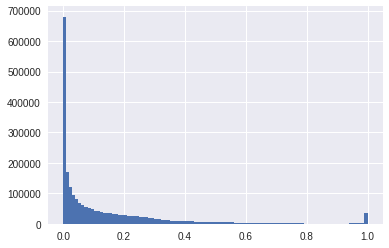

In [112]:
plt.hist(final_probs,bins=100)

In [102]:
# weights[0]*test_preds + weights[1]*link_function(xgb_testpreds)

In [103]:
link_function(xgb_testpreds)

array([[  7.99606723e-05],
       [  1.00031148e-01],
       [  1.89987078e-01],
       ..., 
       [  1.82816463e-05],
       [  6.84190249e-02],
       [  1.48425118e-01]])

In [104]:
df_test = pd.read_csv(data_home+'test.csv')

sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': final_probs.ravel()})
sub.head(2)

,is_duplicate,test_id
0,0.011316,0
1,0.138218,1


In [105]:
submission_name = "subm/ensemble_xgboost_NN_v1.csv"

sub.to_csv(path+submission_name, index=False)
FileLink(submission_name)

/home/ubuntu/quora/subm/ensemble_xgboost_NN_v1.csv